# Pure Pytorch

for every deep learning task in PyTorch, we need:
   * **Data**
   * **device** which set our model to use GPU if it is available.
   * **Model**
   * **Loss function**
   * **Optimizer**
   * **Train** and **Validation/Test** loop. also, our train loop will have the following steps:
      * forward propagation through our network
      * calculate our loss
      * put our previous gradients to zero
      * calculate new gradients
      * update our parameters<br>

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
import torchvision.datasets as datasets
from torchvision import transforms
import os

## Dataset

here we are going to use the MNIST digits dataset which is provided in the PyTorch package so we just need to download it. at the end of the notebook, I'll show how to use your custom datasets for training.

In [8]:
train_dataset = datasets.MNIST(os.getcwd(), train=True,transform=transforms.ToTensor(),download=True)
val_dataset = datasets.MNIST(os.getcwd(), train=False,transform=transforms.ToTensor(),download=True)

some of our hyperparameters:

In [9]:
N_INPUT = 1*28*28
N_HIDDEN = 100
N_OUTPUT = 10
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

In [10]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=8)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=8)

## Set our device to GPU or CPU

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Fully Connected Neural Network

first, we are going to use a fully connected neural network which is not the best choice for image classification. later we will use a convolutional neural network and see how it will effect our accuracy.<br>
**NOTE:** all the models and choice of hyperparameters in this notebook are very simple and it is just for learning purposes. we just need to learn how to use various pieces for our model, and that is our goal here.

### Creating Model

there are various ways to create models in PyTorch but the best way is to use class. our model class has 2 main parts:
   * The `__init__` function contains everything we need for creating our model.
   * The `forward` function which is our forward pass in our model.<br>

**NOTE:** in our class we have to Inheritance `nn.Module`. that is how our model understands the forward method and other methods we are going to use later.<br>
**NOTE:** we can define various functions in our class and use them to create our model (particularly for defining our forward function). keep it mind that some of the names like `forward` are reserved.

In [12]:
class FCNN(nn.Module):
    def __init__(self,n_input,n_hidden,n_output):
        super().__init__()
        self.fc1 = nn.Linear(n_input,n_hidden)
        self.fc2 = nn.Linear(n_hidden,n_hidden)
        self.output = nn.Linear(n_hidden,n_output)
        self.bn1 = nn.BatchNorm1d(n_hidden)
        self.dp = nn.Dropout(0.1)
        
        
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(self.bn1(x))
        x = self.dp(x)
        x = self.fc2(x)
        x = F.relu(self.bn1(x))
        x = self.dp(x)
        x = self.output(x)
        return x

now we instantiate our model with proper inputs that we define in the `__init__` function.<br>
**NOTE:** as you can see we use `.to(device)` to set our device for our **model**. later we have to do this for our **X** and **y** too.

In [13]:
model = FCNN(N_INPUT,N_HIDDEN,N_OUTPUT).to(device)

### Defining Loss and Optimizer

In [14]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE)

### Train and Validation/Test Loop

in PyTorch, we have to define our train and validation/test loop manually. as we said before it contains 5 steps. also in the validation loop, we have to set our model in `eval()` mode and perform forward propagation in `inference_mode()`.these two steps are important specially when we have **dropout** and **batch normalization** in our model.<br>
**NOTE:** one of the advantages of using other PyTorch packages like PyTorch_Lightning and fastai is that it automates these loops for us, so we don't have to write them ourself.

In [15]:
%%time
epochs = 5
for epoch in range(epochs):
    #train loop
    model.train()
    train_losses = []
    for batch_data in train_loader:
        X_train,y_train = batch_data
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        X_train = X_train.reshape(X_train.shape[0],-1)
        
        train_logits = model(X_train) # 1- forward propagation
        cost = loss(train_logits,y_train) # 2- calculating loss
        
        optimizer.zero_grad() # 3- zero previous gradients
        cost.backward() # 4- calculate new gradients
        
        optimizer.step() # 5- update our parameters
        
        train_losses.append(cost.item())
    
    #validation/test loop
    model.eval()
    val_losses = []
    for batch_data in val_loader:
        X_val,y_val = batch_data
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        X_val = X_val.reshape(X_val.shape[0],-1)
        
        with torch.inference_mode():
            val_logits = model(X_val)
        val_cost = loss(val_logits,y_val)
        val_losses.append(val_cost.item())
    print(f'Epoch {epoch + 1} | train loss: {torch.tensor(train_losses).mean():.2f} | validarion loss: {torch.tensor(val_losses).mean():.2f}')

Epoch 1 | train loss: 0.30 | validarion loss: 0.19
Epoch 2 | train loss: 0.14 | validarion loss: 0.16
Epoch 3 | train loss: 0.11 | validarion loss: 0.13
Epoch 4 | train loss: 0.09 | validarion loss: 0.10
Epoch 5 | train loss: 0.08 | validarion loss: 0.12
CPU times: total: 34 s
Wall time: 51.2 s


## Convolutional Neural Network

### Creating Model

In [23]:
class CNN(nn.Module):
    def __init__(self,num_classes=10,num_channel=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=num_channel,kernel_size=5,padding=2,stride=1,bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel)
        self.conv2 = nn.Conv2d(in_channels=num_channel,out_channels=num_channel*2,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(num_channel*2)
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2*num_channel*7*7,num_channel*7*7)
        self.bn3 = nn.BatchNorm1d(num_channel*7*7)
        self.fc2 = nn.Linear(num_channel*7*7,num_classes)
        self.dp = nn.Dropout(0.25)
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.maxpool(x)
        x = self.dp(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.maxpool(x)
        x = self.dp(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(self.bn3(x))
        x = self.dp(x)
        x = self.fc2(x)
        return x
            

In [24]:
model = CNN().to(device)

### Defining Loss and Optimizer

In [25]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)

### Training and Validation/Test Loop

In [26]:
%%time
epochs = 5
for epoch in range(epochs):
    #train loop
    model.train()
    train_losses = []
    for batch_data in train_loader:
        X_train,y_train = batch_data
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        
        train_logits = model(X_train)
        cost = loss(train_logits,y_train)
        
        optimizer.zero_grad()
        cost.backward()
        
        optimizer.step()
        
        train_losses.append(cost.item())
    
    #validation/test loop
    model.eval()
    val_losses = []
    for batch_data in val_loader:
        X_val,y_val = batch_data
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        
        with torch.inference_mode():
            val_logits = model(X_val)
        val_cost = loss(val_logits,y_val)
        val_losses.append(val_cost.item())
    print(f'Epoch {epoch + 1} | train loss: {torch.tensor(train_losses).mean():.2f} | validarion loss: {torch.tensor(val_losses).mean():.2f}')

Epoch 1 | train loss: 0.14 | validarion loss: 0.05
Epoch 2 | train loss: 0.07 | validarion loss: 0.04
Epoch 3 | train loss: 0.06 | validarion loss: 0.03
Epoch 4 | train loss: 0.04 | validarion loss: 0.02
Epoch 5 | train loss: 0.04 | validarion loss: 0.03
CPU times: total: 8min 15s
Wall time: 3min 2s


# Pytorch + Lightning

PyTorch_Lightening is one of the packages that build on top of PyTorch and it adds so much functionality to it. here we are going to just use the basic one which is automating our train and validation loop. but it has so many amazing features. so make sure you check their documentation before using it.

in Lightening we define everything in our model class:
   1) we use `LightningModule` instead of `nn.Module` which has all the methods in `nn.Module` plus some additional methods, which we will use to create our loops.
   2) beside `__init__` and `forward` methods we have to define:
       * `configure_optimizers` which we use to define our optimizers.
       * `training_step` which we use to define our training loop.
       * `validation_step` which we use to define our validation_loop.<br>
       

   3) we don't need to set the device here, and lightning will automatically do it for us.
   4) it will perform 4 of 5 steps in the train loop for us (not forward propagation).
   5) it will automatically set all the necessary modes in our validation loop.<br>

**NOTE:** besides these methods, lightning has more methods that can help us for creating models with more functionality.

In [17]:
import pytorch_lightning as pl

In [18]:
class LFCNN(pl.LightningModule):
    def __init__(self,n_input,n_hidden,n_output):
        super().__init__()
        self.fc1 = nn.Linear(n_input,n_hidden)
        self.fc2 = nn.Linear(n_hidden,n_hidden)
        self.output = nn.Linear(n_hidden,n_output)
        self.bn1 = nn.BatchNorm1d(n_hidden)
        self.dp = nn.Dropout(0.1)
        self.loss = nn.CrossEntropyLoss()
        
        
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(self.bn1(x))
        x = self.dp(x)
        x = self.fc2(x)
        x = F.relu(self.bn1(x))
        x = self.dp(x)
        x = self.output(x)
        return x
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(),lr=LEARNING_RATE)
        return optimizer
    def training_step(self,batch,batch_idx):
        X_train,y_train = batch
        X_train = X_train.reshape(X_train.shape[0],-1)
        logits = self(X_train)
        train_loss = self.loss(logits,y_train)
        self.log("train_loss", train_loss, prog_bar=True, on_step=False, on_epoch=True)
        return train_loss
    def validation_step(self,batch,batch_idx):
        X_val,y_val = batch
        X_val = X_val.reshape(X_val.shape[0],-1)
        logits = self(X_val)
        val_loss = self.loss(logits,y_val)
        self.log("val_loss", val_loss, prog_bar=True, on_step=False, on_epoch=True)
        return val_loss

In [19]:
model = LFCNN(N_INPUT,N_HIDDEN,N_OUTPUT)

in Lightning to train our model, we have to create `.Trainer` which makes everything so much easier. we can set so many things in our trainer so make sure to check their documentation. here we just set our number of epochs.

In [20]:
trainer = pl.Trainer(max_epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


now we just simply use `.fit` method to train our model on our dataset.

In [21]:
%%time
trainer.fit(model,train_dataloaders=train_loader,val_dataloaders=val_loader)


  | Name   | Type             | Params
--------------------------------------------
0 | fc1    | Linear           | 78.5 K
1 | fc2    | Linear           | 10.1 K
2 | output | Linear           | 1.0 K 
3 | bn1    | BatchNorm1d      | 200   
4 | dp     | Dropout          | 0     
5 | loss   | CrossEntropyLoss | 0     
--------------------------------------------
89.8 K    Trainable params
0         Non-trainable params
89.8 K    Total params
0.359     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: total: 39.5 s
Wall time: 1min 26s


# Pytorch + Fastai

fastai is another package that builds on top of PyTorch and again it has so many features in it. here again, we just use some of their functionalities to automate our training and validation loop. so make sure you read their documentation.

here our model is the same model that we define for our PyTorch with very minor changes (which we can do it for the PyTorch model too). instead of flattening our input in our training loop, we flatten our data in our forward method.<br>
then we put our train_loader and val_loader in the `DataLoaders` class from fastai. then we define our `Learner` with proper data, model, loss function, optimization, and metrics. after that, we simply perform the `.fit` method on our learner with the proper number of epochs and other desired settings. here we use the `.fit_one_cycle` method which will do some useful things for us.

In [18]:
from fastai.vision.all import *

In [23]:
data = DataLoaders(train_loader,val_loader)

In [24]:
class FCNN(nn.Module):
    def __init__(self,n_input,n_hidden,n_output):
        super().__init__()
        self.fc1 = nn.Linear(n_input,n_hidden)
        self.fc2 = nn.Linear(n_hidden,n_hidden)
        self.output = nn.Linear(n_hidden,n_output)
        self.bn1 = nn.BatchNorm1d(n_hidden)
        self.dp = nn.Dropout(0.1)
        self.flatten = nn.Flatten()
        
        
    def forward(self,x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(self.bn1(x))
        x = self.dp(x)
        x = self.fc2(x)
        x = F.relu(self.bn1(x))
        x = self.dp(x)
        x = self.output(x)
        return x

In [25]:
model = FCNN(N_INPUT,N_HIDDEN,N_OUTPUT)

In [26]:
learn = Learner(data,model , loss_func=nn.CrossEntropyLoss(), opt_func=Adam, metrics=accuracy)

In [27]:
learn.fit_one_cycle(5,0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.224382,0.303103,0.914600,00:11
1,0.145839,0.222675,0.932600,00:11
2,0.118278,0.145812,0.958700,00:12
3,0.080139,0.157013,0.950700,00:12
4,0.075030,0.159532,0.948500,00:12


# Using Custom Datasets

probably there are various ways to load our custom datasets for training our model but I think this way is much easier at least for me.<br>
here we need to store our train images and test images in 2 different folders. then make sure your image with the same label has something in common for example here we have images of cats and dogs. so each picture of cats has 'cat' in it. it helps us to label our images.<br>
what we going to do is that we create two pandas DataFrame and put image names and corresponding labels in it both for testing and training images. then we use these DataFrames to read images and send them to our model.<br>
for reading our images we create our dataset class which:<br>
   1) have to Inheritance from `Dataset`.
   2) has `__len__` method which return number of samples.
   3) has the `__get__` method which will return our images and labels to our model.<br>

after we define our dataset class we just instantiate our class with proper inputs and then put them in `Dataloader`, and the rest is like what we had before.

In [2]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset,DataLoader

In [3]:
current_path = os.getcwd()
train_path = current_path+"\\all_train_image"
test_path = current_path+"\\all_test_image"

In [4]:
df_train = {'names':[],
      'labels':[]
}
df_test = {'names':[],
      'labels':[]
}

In [5]:
for file in os.listdir(train_path):
    df_train['names'].append(file)
    if 'cat' in file.lower():
        df_train['labels'].append(0)
    elif 'dog' in file.lower():
        df_train['labels'].append(1)

In [6]:
for file in os.listdir(test_path):
    df_test['names'].append(file)
    if 'cat' in file.lower():
        df_test['labels'].append(0)
    elif 'dog' in file.lower():
        df_test['labels'].append(1)

In [7]:
train_csv = pd.DataFrame(df_train)
test_csv = pd.DataFrame(df_test)

In [8]:
class CatsAndDogsDataset(Dataset):
    def __init__(self,train_csv,root_dir,transform=None):
        self.annotation = train_csv
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotation)
    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir,self.annotation.iloc[index,0])
        image = Image.open(img_path)
        y_label = torch.tensor(int(self.annotation.iloc[index,1]))
        
        if self.transform:
            image = self.transform(image)
        return (image,y_label)

In [9]:
train_data = CatsAndDogsDataset(train_csv,train_path,transform=None)
test_data = CatsAndDogsDataset(test_csv,test_path,transform=None)

In [10]:
train_loader = DataLoader(dataset=train_data,batch_size=64,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=64,shuffle=False)

# Transfer Learning

here we are going to use `ResNet50` to train our cats and dogs classifier (on our custom dataset). so we have to:
   1) download the resnet50 model with pre-trained weights.
   2) freeze all the parameters (or maybe some of them) so that they don't change during training.
   3) change the output layer of the model (or some of the layers) according to our problem.

In [11]:
from torchvision.models import resnet50,ResNet50_Weights

In [12]:
parameters = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=parameters)
preprocess = parameters.transforms() # this is our proper preprocessing needed for our model

In [13]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1024, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=2, bias=True)
)

In [15]:
train_data = CatsAndDogsDataset(train_csv,train_path,transform=preprocess)
test_data = CatsAndDogsDataset(test_csv,test_path,transform=preprocess)

In [16]:
train_loader = DataLoader(dataset=train_data,batch_size=64,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=64,shuffle=False)

In [19]:
data = DataLoaders(train_loader,test_loader)

In [20]:
learn = Learner(data,model , loss_func=nn.CrossEntropyLoss(), opt_func=Adam, metrics=accuracy)

In [21]:
learn.fit_one_cycle(1,0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.065309,0.047120,0.984500,14:20


In [45]:
torch.save(learn.model,os.getcwd() + '\\cats_dogs_classifier.pt')

# load model and prediction

In [28]:
import PIL.Image as image

In [47]:
model = torch.load('cats_dogs_classifier.pt')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [86]:
test_image = image.open('dog.jpg')
test_image = preprocess(test_image)
test_image = test_image.unsqueeze(dim=0)

In [87]:
test_image.shape

torch.Size([1, 3, 224, 224])

In [88]:
logits = model(test_image)

In [89]:
classes = ['cat','dog']

In [90]:
prediction = classes[torch.argmax(logits).item()]

In [91]:
prediction

'dog'

In [94]:
model(test_image)

tensor([[-3.1066,  3.0647]], grad_fn=<AddmmBackward0>)

# Grad-CAM

In [66]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [164]:
model = torch.load('cats_dogs_classifier.pt')

In [165]:
for param in model.parameters():
        param.requires_grad = True

In [166]:
target_layers = [model.layer4[-1]]

In [167]:
cam = GradCAM(model=model, target_layers=target_layers)

In [168]:
grayscale_cam = cam(input_tensor=test_image, targets=None)

In [169]:
grayscale_cam = grayscale_cam[0, :]

In [170]:
img = image.open('dog.jpg')
img = img.resize((224,224))
img = np.array(img,dtype=np.float32)/255.0

In [178]:
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

In [179]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'prediction: dog')

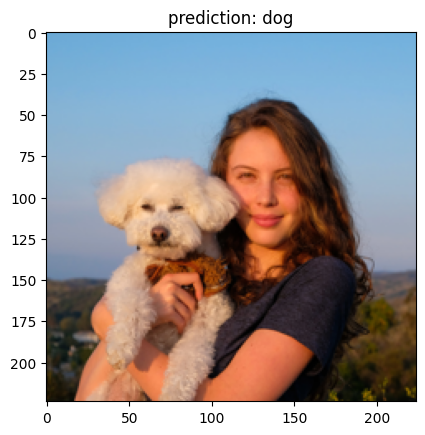

In [180]:
plt.imshow(img)
plt.title(f'prediction: {prediction}')

Text(0.5, 1.0, 'Grad-CAM')

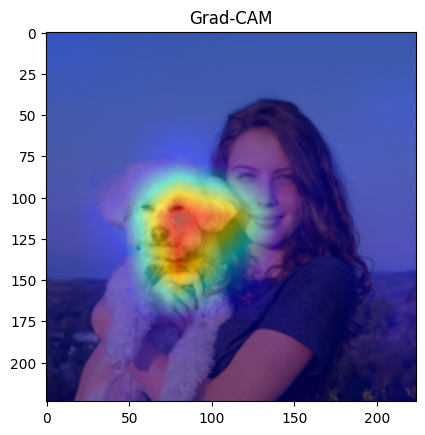

In [182]:
plt.imshow(visualization)
plt.title('Grad-CAM')